In [12]:
import sys

import scipy.io
import torch
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay  #导入评分模块
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

from mmsc.dataset import TabularDataset
from mmsc.scloss import SupConLoss
from mmsc.model import MMSCARF
from mmsc.utils import dataset_embeddings, fix_seed, train_epoch

In [13]:
def evaluate_model(test_target, vanilla_predictions, the_labels):
    acc = accuracy_score(test_target, vanilla_predictions)
    print("ACC: " + str(acc))
    
    cm = confusion_matrix(test_target, vanilla_predictions, labels=the_labels)
    sen = cm[1, 1] / (cm[1, 1] + cm[1, 0])
    spe = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    
    print("SEN: ", sen)
    print("SPE: ", spe)
    
    return acc, sen, spe

In [14]:
#simulated data
num_rows = 200

random_data_A = np.random.rand(num_rows, 400)
random_data_B = np.random.rand(num_rows, 100)
random_data_C = np.random.rand(num_rows, 200)


df_A = pd.DataFrame(random_data_A, columns=[f'Column_{i}' for i in range(400)])
df_B = pd.DataFrame(random_data_B, columns=[f'Column_{i}' for i in range(100)])
df_C = pd.DataFrame(random_data_C, columns=[f'Column_{i}' for i in range(200)])

target_data = np.random.choice([1, 2], size=(num_rows, 1))
target = pd.DataFrame(target_data, columns=['Label'])

# Standlization
Alldataset = [df_A, df_B, df_C]

scaled_dataset = []
scaler = StandardScaler()
for dataset in Alldataset:
    scaled_data = scaler.fit_transform(dataset)
    scaled_df = pd.DataFrame(scaled_data, columns=dataset.columns, index=dataset.index)
    scaled_dataset.append(scaled_df)
Alldataset = scaled_dataset

In [15]:
#Prepare all needed parameters
batch_size = 256
randomseed = 666
#model
embeddim_poj = 64
epochs = 100
encoder_depth = 6
head_depth = 4
dropout = 0.1
dropout_poj = 0.1
feature_sparsity = 0.3
learnable_sparsity = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#optimizer
lr = 1e-2
#loss
temperature = 0.07
contrast_mode = 'all'
base_temperature = 0.07
#svm
C = 0.1
kernel = 'linear'
select_parameter = False

In [16]:
fix_seed(randomseed)

#Standlization
scaler = StandardScaler()
scaled_dataset = []

for dataset in Alldataset:
    scaled_data = scaler.fit_transform(dataset)
    scaled_df = pd.DataFrame(scaled_data, columns=dataset.columns, index=dataset.index)
    scaled_dataset.append(scaled_df)
    
Alldataset = scaled_dataset

#Split dataset
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=333)
for count, (train_index, test_index) in enumerate(skf.split(Alldataset[0], target)):
    train_datas = [dataset.iloc[train_index] for dataset in Alldataset]
    test_datas = [dataset.iloc[test_index] for dataset in Alldataset]
    train_target, test_target = target.iloc[train_index], target.iloc[test_index]
    break


train_ds = TabularDataset(
            train_datas,
            train_target.to_numpy()
        )
test_ds = TabularDataset(
            test_datas,
            test_target.to_numpy()
        )

print(f"The shape of data in train_ds are:\n{train_ds.shape}")
print(f"The shape of data in test_ds are:\n{test_ds.shape}")

The shape of data in train_ds are:
[(160, 400), (160, 100), (160, 200)]
The shape of data in test_ds are:
[(40, 400), (40, 100), (40, 200)]


In [17]:
#Construct the model
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

input_dims, emb_dims = [],[]
for data in train_ds.data:
    input_dims.append(data.shape[1])
    emb_dims.append(int(data.shape[1]/2))

img_snp_model = MMSCARF(
            input_dims = input_dims, 
            emb_dims= emb_dims,
            project_dim=embeddim_poj,
            encoder_depth=encoder_depth,
            head_depth=head_depth,
            dropout=dropout,
            dropout_poj=dropout_poj,
            feature_sparsity=feature_sparsity,
            learnable_sparsity=learnable_sparsity
        ).to(device)

optimizer = Adam(img_snp_model.parameters(), lr)

mmcon_loss = SupConLoss(temperature, contrast_mode, base_temperature)

In [18]:
#Training
loss_history = []
for epoch in range(1, epochs + 1):
    epoch_loss = train_epoch(img_snp_model, mmcon_loss, train_loader, optimizer, device, epoch)
    loss_history.append(epoch_loss)

<function matplotlib.pyplot.show(close=None, block=None)>

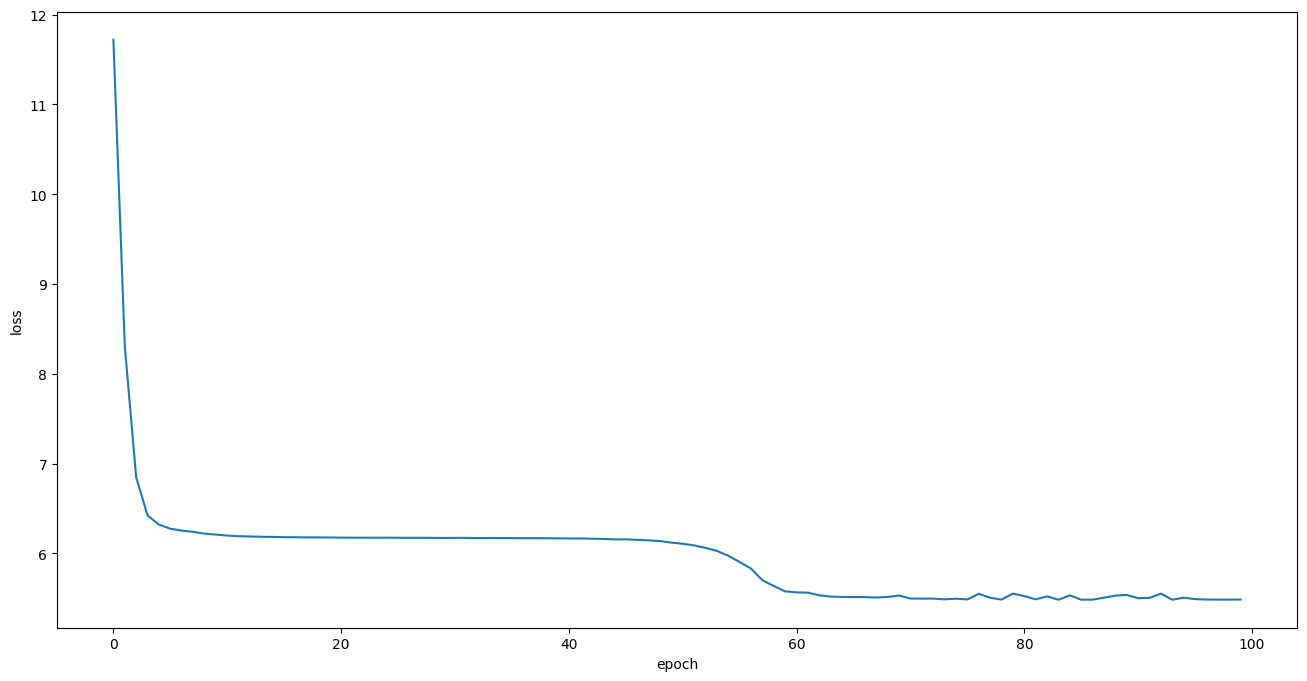

In [19]:
#loss fig
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

plt.show

In [20]:
#get embedings
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

train_embeddings = dataset_embeddings(img_snp_model, train_loader, device)
test_embeddings = dataset_embeddings(img_snp_model, test_loader, device)

try:
    train_datas = [data.values for data in train_datas]
    test_datas = [data.values for data in test_datas]
except AttributeError:
    print("Already turned into values")

for i, array in enumerate(train_embeddings):
    print(f"Train_embedding {i + 1}:", end=" ")
    print("Shape:", array.shape, end=" ")
    print("Size:", array.size)
    
for i, array in enumerate(test_embeddings):
    print(f"Test_embedding {i + 1}:", end=" ")
    print("Shape:", array.shape, end=" ")
    print("Size:", array.size)

100%|██████████| 1/1 [00:00<00:00, 77.89it/s]

Train_embedding 1: Shape: (160, 400) Size: 64000
Train_embedding 2: Shape: (160, 100) Size: 16000
Train_embedding 3: Shape: (160, 200) Size: 32000
Test_embedding 1: Shape: (40, 400) Size: 16000
Test_embedding 2: Shape: (40, 100) Size: 4000
Test_embedding 3: Shape: (40, 200) Size: 8000


In [21]:
#concret
train_datas_fusion = np.concatenate(train_datas, axis=1)
test_datas_fusion = np.concatenate(test_datas, axis=1)

train_embeddings_fusion = np.concatenate(train_embeddings, axis=1)
test_embeddings_fusion = np.concatenate(test_embeddings, axis=1)

the_labels = target["Label"].unique().tolist()
if(the_labels[0] > the_labels[1]):
    the_labels[0], the_labels[1] = the_labels[1], the_labels[0]

print(train_datas_fusion.shape)
print(train_embeddings_fusion.shape)

(160, 700)
(160, 700)


In [22]:
mlp = MLPClassifier(hidden_layer_sizes=(64,32), activation='relu',
                    solver='adam', alpha=0.0001, random_state=randomseed)


mlp.fit(train_datas_fusion, train_target)
vanilla_predictions = mlp.predict(test_datas_fusion)
print("------Results of origin data------")
acc, sen, spe = evaluate_model(test_target, vanilla_predictions, the_labels)
vanilla_predictions = mlp.predict(train_datas_fusion)
print("ACC of the training set:{}".format(accuracy_score(train_target, vanilla_predictions)))

mlp.fit(train_embeddings_fusion, train_target)
thresholds = np.arange(-1.5, 1.5, 0.01)
best_threshold = 0
best_sen = 0
best_spe = 0
best_acc = 0

for threshold in thresholds:

    confidence_scores = mlp.predict_proba(test_embeddings_fusion)

    predictions = np.where(confidence_scores[:,1] > threshold, the_labels[1], the_labels[0])

    tn, fp, fn, tp = confusion_matrix(test_target, predictions).ravel()
    current_sen = tp / (tp + fn)
    current_spe = tn / (tn + fp)
    current_acc = (tp + tn) / (tp + tn + fp + fn)
    

    if 0.1*current_acc + current_sen + current_spe > 0.1*best_acc + best_sen + best_spe:
    #if current_sen + current_spe > best_sen + best_spe:
        best_sen = current_sen
        best_spe = current_spe
        best_threshold = threshold
        best_acc = current_acc

final_predictions = np.where(confidence_scores[:,1] > best_threshold, the_labels[1], the_labels[0])
print(best_threshold)
vanilla_predictions = mlp.predict(test_embeddings_fusion)
print("------Results of the embeddings------")
acc, sen, spe = evaluate_model(test_target, final_predictions, the_labels)
vanilla_predictions = mlp.predict(train_embeddings_fusion)
print("ACC of the training set{}".format(accuracy_score(train_target, vanilla_predictions)))


d:\Anaconda\envs\SC\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\envs\SC\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


------基于原始数据------
ACC: 0.525
SEN:  0.47368421052631576
SPE:  0.5714285714285714
训练集准确率为1.0
0.7900000000000018
------基于表征数据------
ACC: 0.65
SEN:  0.631578947368421
SPE:  0.6666666666666666
训练集准确率为1.0


<function matplotlib.pyplot.show(close=None, block=None)>

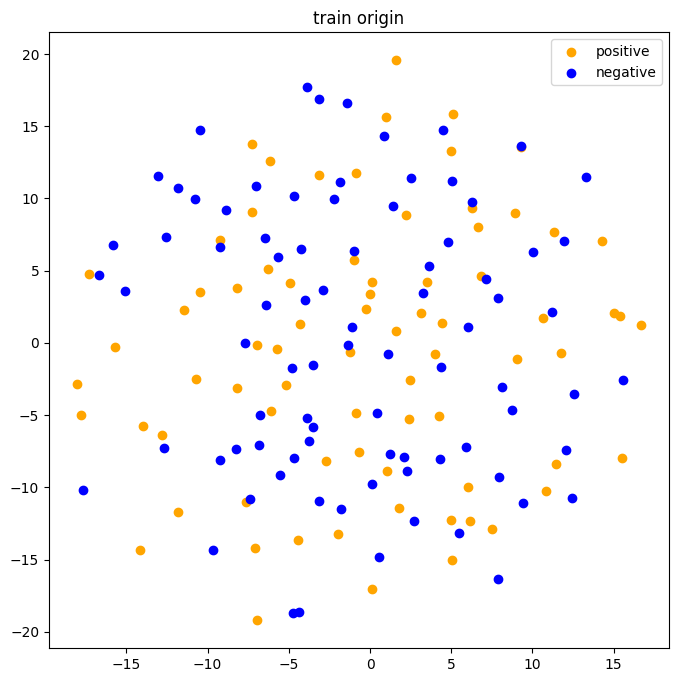

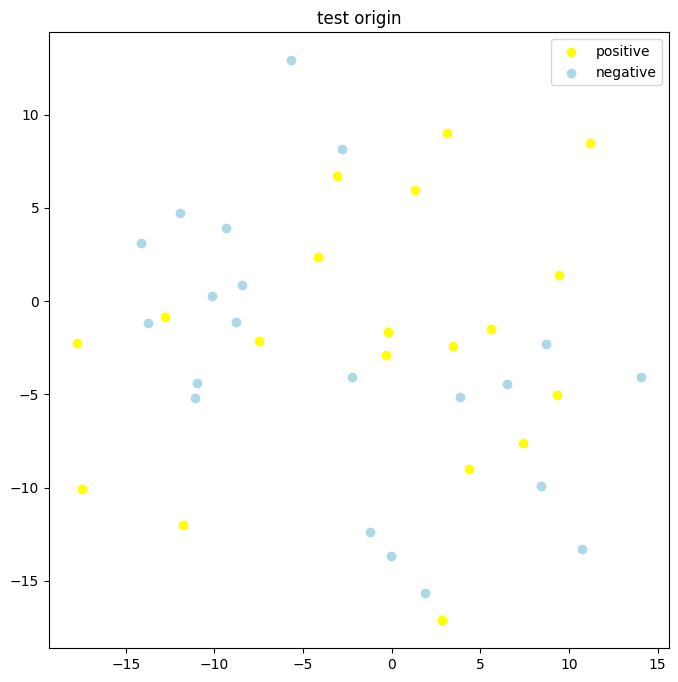

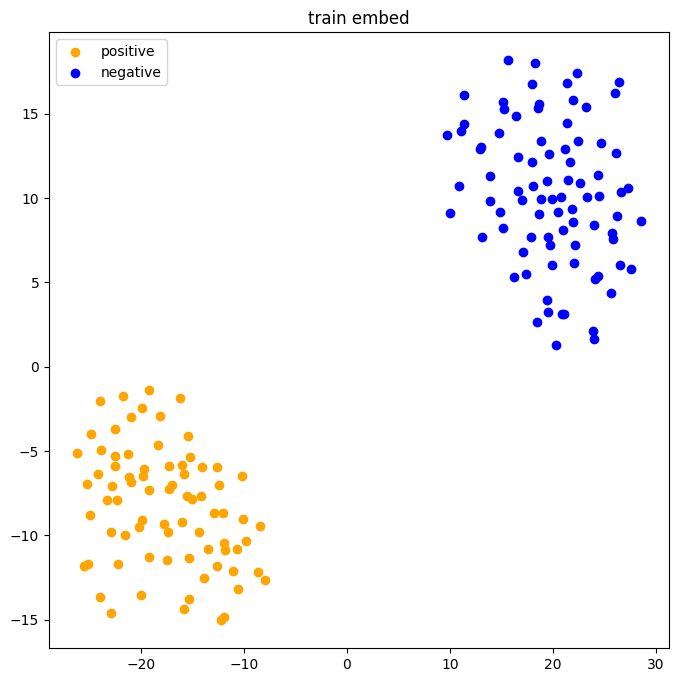

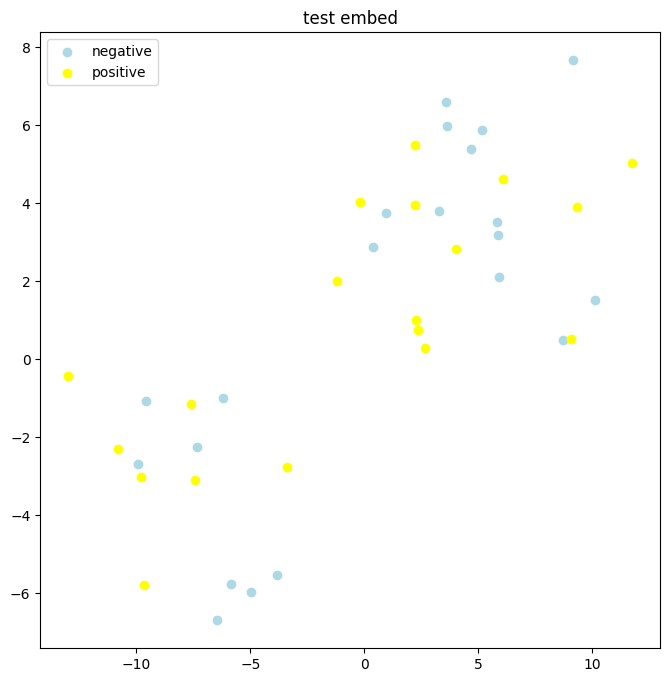

In [23]:
#visulization
origin_data = np.concatenate((train_datas_fusion, test_datas_fusion), axis=0)
embed_data = np.concatenate((train_embeddings_fusion, test_embeddings_fusion), axis=0)

tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=15)
reduced = tsne.fit_transform(origin_data)
positive_a = train_target['Label'] == 2
positive_b = test_target['Label'] == 2

reduced_train_data = reduced[:len(train_datas_fusion)]
reduced_test_data = reduced[len(train_datas_fusion):]

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(reduced_train_data[positive_a, 0], reduced_train_data[positive_a, 1], c='orange', label="positive")
ax.scatter(reduced_train_data[~positive_a, 0], reduced_train_data[~positive_a, 1], c='blue', label="negative")
plt.legend()
plt.title("train origin")
plt.show
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(reduced_test_data[positive_b, 0], reduced_test_data[positive_b, 1], c='yellow', label="positive")
ax.scatter(reduced_test_data[~positive_b, 0], reduced_test_data[~positive_b, 1], c='lightblue', label="negative")
plt.legend()
plt.title("test origin")
plt.show



reduced = tsne.fit_transform(embed_data)
positive_a = train_target['Label'] == 2
positive_b = test_target['Label'] == 2

reduced_train_embed = reduced[:len(train_embeddings_fusion)]
reduced_test_embed = reduced[len(train_embeddings_fusion):]
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(reduced_train_embed[positive_a, 0], reduced_train_embed[positive_a, 1], c='orange', label="positive")
ax.scatter(reduced_train_embed[~positive_a, 0], reduced_train_embed[~positive_a, 1], c='blue', label="negative")
plt.legend()
plt.title("train embed")
plt.show
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(reduced_test_embed[~positive_b, 0], reduced_test_embed[~positive_b, 1], c='lightblue', label="negative")
ax.scatter(reduced_test_embed[positive_b, 0], reduced_test_embed[positive_b, 1], c='yellow', label="positive")
plt.legend()
plt.title("test embed")
plt.show

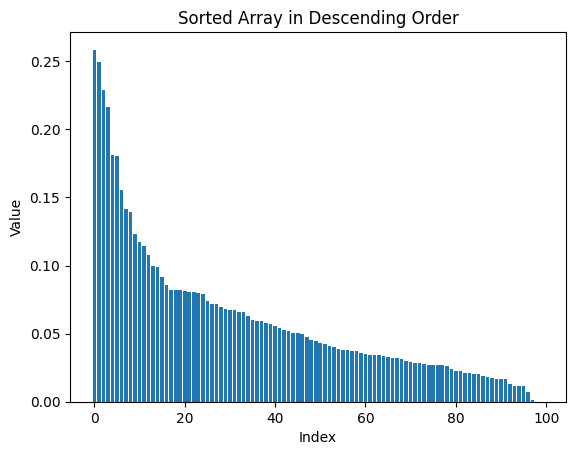

In [24]:
# importance ranking
feature_importance = img_snp_model.feature_importance()
sorted_arr = np.sort(feature_importance[1])[::-1] 
plt.bar(np.arange(len(sorted_arr)), sorted_arr)

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Sorted Array in Descending Order')

plt.show()

In [25]:
feature_importance[1]

array([8.54494870e-02, 5.02356701e-02, 2.07007602e-02, 3.88573557e-02,
       2.70841606e-02, 8.09367001e-02, 8.20150524e-02, 7.42055327e-02,
       8.11150372e-02, 1.03981805e-03, 2.14287676e-02, 1.80744797e-01,
       4.98234667e-02, 2.87199840e-02, 1.87882800e-02, 7.20550194e-02,
       3.44659723e-02, 3.79102826e-02, 6.88680960e-03, 7.19956458e-02,
       1.68462154e-02, 7.95571432e-02, 2.70981453e-02, 9.93929356e-02,
       2.96596736e-02, 3.60060818e-02, 1.55439138e-01, 7.93671831e-02,
       3.40291820e-02, 4.28378135e-02, 2.24862881e-02, 1.17458105e-01,
       3.75038832e-02, 1.17357206e-02, 3.10525782e-02, 5.73948696e-02,
       3.44524086e-02, 1.14237601e-02, 5.89349046e-02, 8.07441026e-02,
       3.69012058e-02, 6.01622686e-02, 6.56908378e-02, 1.63848978e-02,
       3.23453099e-02, 7.41779349e-09, 4.26497012e-02, 3.18308100e-02,
       5.78846969e-02, 2.58541167e-01, 3.35527509e-02, 1.18888663e-02,
       4.07834649e-02, 2.92162746e-02, 3.26361060e-02, 2.49636248e-01,
      